# Training the model

In this article, we will make a image classification model that attempts to differentiate between aliens and ghosts. Although it is possible to only use CPU to train the model, it is faster to use GPU. I am on Google colab, which provides free GPU. After training, we will save the model so that we can use it for deployment on Hugging Face spaces.

First, we import FastAI library.

In [ ]:
!pip install -Uqq fastai
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.vision.widgets import *

     |████████████████████████████████| 719 kB 20.2 MB/s 
     |████████████████████████████████| 5.3 MB 40.7 MB/s 
     |████████████████████████████████| 441 kB 44.3 MB/s 
     |████████████████████████████████| 1.3 MB 6.6 MB/s 
     |████████████████████████████████| 1.6 MB 50.2 MB/s 
     |████████████████████████████████| 95 kB 5.6 MB/s 
     |████████████████████████████████| 115 kB 67.4 MB/s 
     |████████████████████████████████| 163 kB 62.5 MB/s 
     |████████████████████████████████| 212 kB 70.8 MB/s 
     |████████████████████████████████| 127 kB 68.1 MB/s 
     |████████████████████████████████| 115 kB 57.5 MB/s 
     |████████████████████████████████| 7.6 MB 61.9 MB/s 
Mounted at /content/gdrive


## Collect Data

We use duckduckgo to search and download images. FastAI provides `search_images_ddg` so that we do not have to go to a search engine and download an image one by one!

In [ ]:
search_results = search_images_ddg('alien images')

In [ ]:
ims = search_results
len(ims)

200

In [ ]:
dest = 'images/aliens'
download_url(ims[2], dest)

Path('images/aliens')

We can check the image and see if it looks right. It seems like an alien.

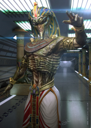

In [ ]:
im = Image.open(dest)
im.to_thumb(128, 128)

Now we download images to our path. We create two directories, alien and ghost, and download each category of images into each directory.

In [ ]:
category_types = 'alien', 'ghost'
path = Path('alien_ghost')

In [ ]:
if not path.exists():
    path.mkdir()
    for o in category_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_ddg(f'{o} images')
        download_images(dest, urls=results)

In [ ]:
fns = get_image_files(path)
fns

(#397) [Path('alien_ghost/alien/5d727cc0-806f-4ec4-83ae-d7c06f43ec9e.jpg'),Path('alien_ghost/alien/f2ffe42f-c61b-45f9-b36f-68cf6de088c6.jpg'),Path('alien_ghost/alien/18ec3bc4-6884-492b-a36b-f24b74fefb55.jpg'),Path('alien_ghost/alien/0411337c-49a6-457b-9091-44e21a2a1671.jpg'),Path('alien_ghost/alien/4d33d45f-c3cb-48e2-82ac-29673e9e7fc0.jpg'),Path('alien_ghost/alien/f1774ead-0ca1-4bc8-9522-f6517b1009f3.jpg'),Path('alien_ghost/alien/eb4d7087-f726-453a-b017-3898dadd1fdb.jpg'),Path('alien_ghost/alien/bcbea1c7-0521-4bd3-96e3-fe3c908ad0ea.jpg'),Path('alien_ghost/alien/546f275e-4cad-4db8-ac7f-bbece1b556de.png'),Path('alien_ghost/alien/250d3e56-a7be-4604-a184-7518e1f235ef.jpg')...]

Failed one are ones that cannot be opened, so we unlink them from our path.

In [ ]:
failed = verify_images(fns)
failed

(#8) [Path('alien_ghost/alien/8b2cfce8-de67-49ea-8171-4144400bdf22.jpg'),Path('alien_ghost/alien/d77ad0bd-a6cd-48bd-8696-044bf574420d.jpg'),Path('alien_ghost/ghost/d993cf0e-769b-4eb0-ae9e-c5a2233e373c.jpg'),Path('alien_ghost/ghost/49ae4580-2a18-4bab-af79-4ffb79f8a5ca.jpg'),Path('alien_ghost/ghost/4f5bded3-f543-4dd7-995a-ae3af65b7e58.gif'),Path('alien_ghost/ghost/e7ed422d-d757-457c-9de4-d4795efa9289.jpg'),Path('alien_ghost/ghost/343f6aca-79f2-481f-a5ec-66f9787d6543.jpg'),Path('alien_ghost/ghost/138e762f-875d-4bd2-889d-5d6866ebabff.gif')]

In [ ]:
failed.map(Path.unlink)

(#8) [None,None,None,None,None,None,None,None]

## DataLoaders

We now create DataBlocks. Simply put, it is a bridge between raw data and a model. We specify input and output for the model, how to get the input, how to split train data from validation data, how data are labelled, and what transfroms are needed for the input. 

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),               # We take images and try to classify them based on categories.
    get_items=get_image_files,                        # inputs are images.
    splitter=RandomSplitter(valid_pct=0.2, seed=42),  # randomly pick 20% of the input for validation.
    get_y=parent_label,                               # parent directory name is the label for each image.
    item_tfms=Resize(128))                            # Resize each image to 128.

In [ ]:
dls = dblock.dataloaders(path)
dls

<fastai.data.core.DataLoaders>

Look at the images and labels to make sure everything looks right. Seems like images are correctly labelled. At this point, it is okay to have some wrong images or labels. We will fix that later.

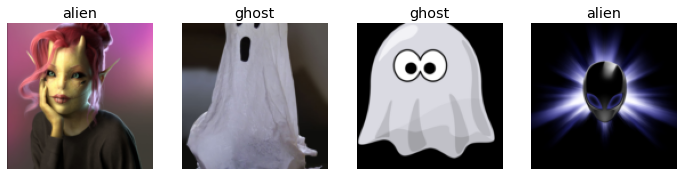

In [ ]:
dls.valid.show_batch(max_n=4, nrows=1)

We can add data augmentation (transforms) into images so that we can train more efficiently with less data.

In [ ]:
dblock = dblock.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = dblock.dataloaders(path)

Now we train the model.

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


There are some errors. We can look at the errors by looking at the confusion matrix and top losses.

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


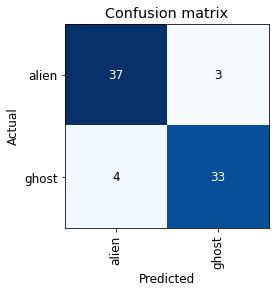

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


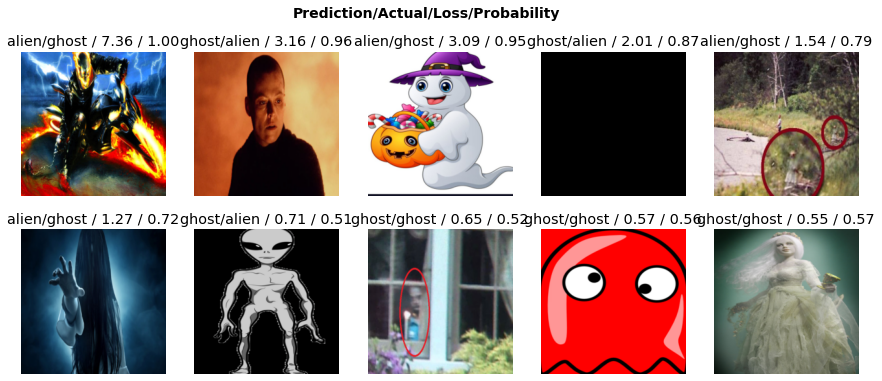

In [ ]:
# Check the high losses
interp.plot_top_losses(10, nrows=2)

Some images are not labelled correctly or wrong images. We can easily fix it by using the cleaner. 

In [ ]:
# Pick which ones to delete or to move to another category
cleaner = ImageClassifierCleaner(learn)
cleaner

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [ ]:
# make cleaner take effect
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

After cleaning, we train again for the cleaned data. So, we go back up to DataLoaders and come back down here. After that, we can export the model. We can then download the model so that we can deploy it into Hugging Face Spaces.

In [ ]:
learn.export()

In [ ]:
# check if file is pickled
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

That's it. If this notebook was run locally, there will be the the model in the same directory as the notebook. If this notebook was run on Google colab, the model has to be downloaded from the directory from the panel on the left. 